In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from Model import FCN
from Dataset import DatasetHandler
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(123)

class PINN():
    "Defines a PINNs. Input (t, x) => Output (T_f, T_s)"
    def __init__(self, N_INTERIOR, N_INITIAL, N_BOUNDARY):
        super().__init__()
        self.n_interior_ = N_INTERIOR # number of interior point
        self.n_initial_ = N_INITIAL # number of points for initial condition
        self.n_boundary_ = N_BOUNDARY # number of points for boundary condition

        self.alpha_f = 0.05
        self.alpha_s = 0.08
        self.h_f = 5 # heat transfer fluid
        self.h_s = 6 # heat transfer solid
        self.T_hot = 4
        self.T_0 = 1
        self.u_f = 1 # thermal_conductivity

        # Set extrema for solution domain of t and x
        self.domain_boundaries = torch.tensor([[0.0,1.0], [0.0,1.0]])

        self.model = FCN(IN_DIM=self.domain_boundaries.shape[0], OUT_DIM=2,
                                            N_HIDDEN_LAYERS=4, N_NEURONS=20, REGULARIZE_PARAM=0.,
                                            REGULARIZE_EXP=2.)

        # Sobol sequence generator for input sampling
        self.sobol_gen = torch.quasirandom.SobolEngine(dimension=self.domain_boundaries.shape[0])
        self.dataset_handler = DatasetHandler(self.sobol_gen, self.domain_boundaries)
        self.training_sets = self.dataset_handler.create_datasets(self.n_interior_, self.n_boundary_, self.n_initial_)
        # [interior_points, boundary_loader, initial_loader]
        # note: only input_batch, because output_batch is not defined for PDE problems

    #def predict_initial_points(self, input_data):
    #    # input_data = initial points in Data Loader
    #    return self.model(input_data)

    #def predict_boundary_points(self, input_data):
    #    # input_data = initial points in Data Loader
    #    return self.model(input_data)

    def compute_initial_loss(self, initial_points):
        """"
        Compute sum of residual in the initial condition: Tf(x,t=0) + Ts(x,t=0).
        In the initial condition, this expression is supposed to be 0.

        Params:
        initial_points (tensor): 2D tensor of boundary points, shape of [n_points, 2]

        Returns:
        initial_residual (tensor): sum of residual in initial condition
        """
        #initial_points.requires_grad=True
        predictions_t0 = self.model(initial_points)
        Tf_t0_pred = predictions_t0[:,0]
        Ts_t0_pred = predictions_t0[:,1]
        #T_f_t0_residual = torch.sum((T_f_t0-self.T_0)**2)
        #T_s_t0_residual = torch.sum((T_s_t0-self.T_0)**2)
        #initial_residual = T_f_t0_residual + T_s_t0_residual
        Tf_t0_loss = torch.mean((Tf_t0_pred - self.T_0) ** 2)  # MSE for T_f
        Ts_t0_loss = torch.mean((Ts_t0_pred - self.T_0) ** 2)  # MSE for T_s

        # Total initial residual (average over all points)
        initial_residual = Tf_t0_loss + Ts_t0_loss

        return initial_residual

    def compute_boundary_loss(self, boundary_points):
        # boundary_points (tensor): 2D tensor of boundary points [n_points, 2]
        # boundary (2)
        boundary_points.requires_grad=True

        mask_x0 = boundary_points[:, 0] == self.domain_boundaries[1, 0]
        mask_xL = boundary_points[:, 0] == self.domain_boundaries[1, 1]

        boundary_points_x0 = boundary_points[mask_x0]
        boundary_points_xL = boundary_points[mask_xL]
        x0_boundary = boundary_points_x0[:,0]
        xL_boundary = boundary_points_xL[:,0]
        t_boundary_x0 = boundary_points_x0[:, 1]

        #boundary_points_x0.requires_grad = True
        #boundary_points_xL.requires_grad = True
        #t = boundary_points[:,1] # tensor of time values

        predictions_x0 = self.model(boundary_points_x0)
        predictions_xL = self.model(boundary_points_xL)

        Tf_x0_pred, Ts_x0_pred = predictions_x0[:, 0], predictions_x0[:, 1]
        Tf_xL_pred, Ts_xL_pred = predictions_xL[:, 0], predictions_xL[:, 1]


        T_boundary = (self.T_hot - self.T_0) / (1 + torch.exp(-20*(t_boundary_x0-0.25))) + self.T_0 # this sigmoid is very steep

        boundary_2_loss = torch.mean((T_boundary - Tf_x0_pred)**2)

        #boundary_point_ = torch.tensor([[0.,1.]])
        #predict_ = self.model(boundary_point_)
        #one = torch.tensor([1.0])
        #T_boundary_ = (self.T_hot - self.T_0) / (1 + torch.exp(-200*(one-0.25))) + self.T_0

        # Boundary conditions 1
        dTs_x0 = torch.autograd.grad(Ts_x0_pred.sum(), boundary_points_x0, create_graph=True)[0][:,0]
        dTs_xL = torch.autograd.grad(Ts_xL_pred.sum(), boundary_points_xL, create_graph=True)[0][:,0]
        dTf_xL = torch.autograd.grad(Tf_xL_pred.sum(), boundary_points_xL, create_graph=True)[0][:,0] # get dx column, not dt

        boundary_1_loss = torch.mean(dTs_x0**2 + dTs_xL**2 + dTf_xL**2)
        boundary_loss = boundary_1_loss + boundary_2_loss

        #boundary_1_residual = abs(dTs_x0) + abs(dTs_xL) + abs(dTf_xL)

        return boundary_loss # boundary_1_residual.reshape(-1,1), boundary_2_residual.reshape(-1,1)

    def compute_pde_loss(self, interior_points):
        interior_points.requires_grad = True
        predictions = self.model(interior_points)

        Tf_pred = predictions[:, 0]
        Ts_pred = predictions[:, 1]

        dTf = torch.autograd.grad(Tf_pred.sum(), interior_points, create_graph=True)[0]
        dTs = torch.autograd.grad(Ts_pred.sum(), interior_points, create_graph=True)[0]

        dTf_dx = dTf[:, 0]
        dTf_dt = dTf[:, 1]
        dTs_dx = dTs[:, 0]
        dTs_dt = dTs[:, 1]

        d2Tf = torch.autograd.grad(dTf.sum(), interior_points, create_graph=True)[0]
        d2Ts = torch.autograd.grad(dTs.sum(), interior_points, create_graph=True)[0]

        d2Ts_dx2 = d2Ts[:,0]
        d2Tf_dx2 = d2Tf[:,0]

        residual_fluid = (dTf_dt) + (self.u_f * dTf_dx) - (self.alpha_f * d2Tf_dx2) + (self.h_f * (Tf_pred - Ts_pred))
        residual_solid = (dTs_dt) - (self.alpha_s * d2Ts_dx2) - (self.h_s * (Tf_pred - Ts_pred))

        # add sum of residual fluid and residual solid
        #residual_fluid = residual_fluid.reshape(-1,)
        #residual_solid = residual_solid.reshape(-1,)

        # MSE

        fluid_loss = torch.mean(residual_fluid**2) # 1/self.n_interior_ * torch.sum(residual_fluid**2)
        solid_loss = torch.mean(residual_solid**2) #1/self.n_interior_ * torch.sum(residual_solid**2)

        #total_pde_residual = residual_fluid + residual_solid
        total_loss = fluid_loss + solid_loss
        return total_loss

    def compute_loss(self, interior_data, boundary_data, initial_data):
        # data in 2D tensor
        #boundary_residual_1, boundary_residual_2 = self.compute_boundary_residual(boundary_data)
        #boundary_residual = boundary_residual_2 + boundary_residual_1
        boundary_loss = self.compute_boundary_loss(boundary_data)

        #print("Boundary residual 1: ", boundary_residual_1)
        initial_loss = self.compute_initial_loss(initial_data)
        #temporal_preds = self.apply_initial_conditions(initial_data)
        #intial_residual = self.compute_boundary_residual
        pde_loss = self.compute_pde_loss(interior_data)

        #abs(): argument 'input' (position 1) must be Tensor, not tuple
        #boundary_loss = torch.mean(torch.abs(boundary_residual) ** 2)

        #initial_loss = torch.mean(torch.abs(initial_residual) ** 2)

        #temporal_loss = torch.mean(torch.abs(temporal_data[1] - temporal_preds) ** 2)
        #pde_loss = pde_residuals # torch.mean(torch.abs(pde_residuals[0]) ** 2) + torch.mean(torch.abs(pde_residuals[1]) ** 2)

        total_loss = initial_loss + pde_loss + boundary_loss
        print("Total loss: ", round(total_loss.item(), 4), "| PDE Loss: ", round(pde_loss.item(), 4), "| Conditions Loss: ", round(boundary_loss.item() + initial_loss.item(), 4))
        return total_loss

    def fit(self, epochs, optimizer):
        history = []
        for batch in zip(*self.training_sets):
            [interior_points_, boundary_points_, initial_points_] = batch
        for epoch in range(epochs):
            # self.training_sets = [interior_loader, boundary_loader, initial_loader]
            #print(boundary_points_)
            print("Number of epoch", epoch)
            def closure():
                optimizer.zero_grad()
                loss = self.compute_loss(interior_points_[0], boundary_points_[0], initial_points_[0]) # batch = [2D interioir, 2D boundary, 2D initial]
                loss.backward()
                history.append(loss.item())
                return loss
            optimizer.step(closure)

            if (epoch % 500 == 0):
                self.visualize_results()

        return history

    def visualize_results(self):
        # solver
        test_points = solver.sobol_gen.draw(10000)
        output = solver.model(test_points)

        Tf_pred = output[:, 0].reshape(-1,)
        Ts_pred = output[:, 1].reshape(-1,)

        fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

        # Plot for Tf
        im1 = axs[0].scatter(test_points[:, 0].detach(), test_points[:, 1].detach(), c=Tf_pred.detach(), cmap="jet")
        axs[0].set_xlabel("Position (x)")
        axs[0].set_ylabel("Time (t)")
        axs[0].grid(True, which="both", ls=":")
        axs[0].set_title("Approximate Solution $T_f$")
        # Colorbar for Tf plot
        cbar1 = plt.colorbar(im1, ax=axs[0])
        cbar1.set_label("Temperature $T_f$", rotation=270, labelpad=15)

        # Plot for T_s
        im2 = axs[1].scatter(test_points[:, 0].detach(), test_points[:, 1].detach(), c=Ts_pred.detach(), cmap="jet")
        axs[1].set_xlabel("Position (x)")
        axs[1].set_ylabel("Time (t)")
        axs[1].grid(True, which="both", ls=":")
        axs[1].set_title("Approximate Solution $T_s$")

        cbar2 = plt.colorbar(im2, ax=axs[1])
        cbar2.set_label("Temperature $T_s$", rotation=270, labelpad=15)

        plt.show()

Number of epoch 0
Total loss:  16.7369 | PDE Loss:  1.1591 | Conditions Loss:  15.5777


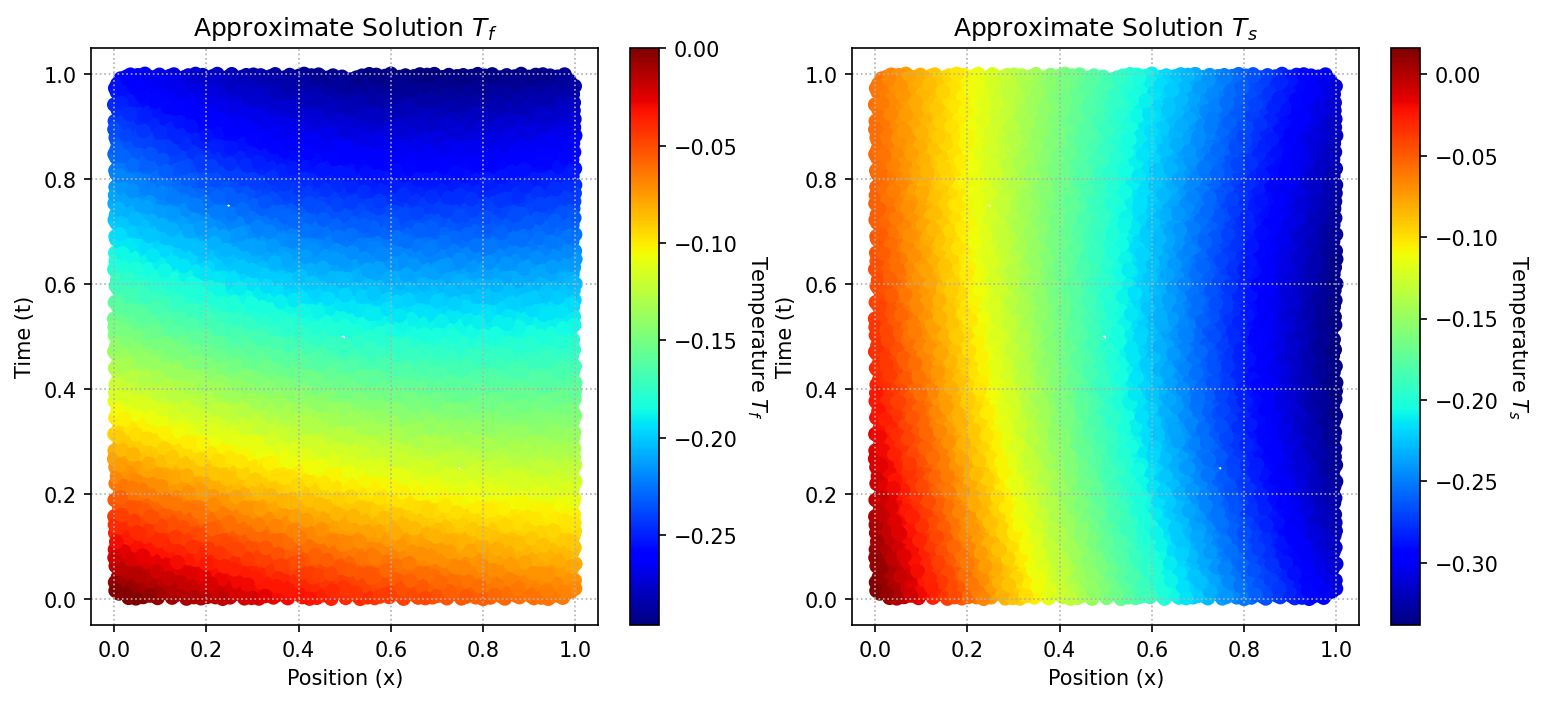

Number of epoch 1
Total loss:  16.0313 | PDE Loss:  0.7162 | Conditions Loss:  15.3152
Number of epoch 2
Total loss:  15.4814 | PDE Loss:  0.5136 | Conditions Loss:  14.9678
Number of epoch 3
Total loss:  14.9192 | PDE Loss:  0.3179 | Conditions Loss:  14.6014
Number of epoch 4
Total loss:  14.421 | PDE Loss:  0.1861 | Conditions Loss:  14.2349
Number of epoch 5
Total loss:  14.0118 | PDE Loss:  0.132 | Conditions Loss:  13.8798
Number of epoch 6
Total loss:  13.6561 | PDE Loss:  0.1091 | Conditions Loss:  13.5469
Number of epoch 7
Total loss:  13.3241 | PDE Loss:  0.0833 | Conditions Loss:  13.2408
Number of epoch 8
Total loss:  13.0196 | PDE Loss:  0.0618 | Conditions Loss:  12.9578
Number of epoch 9
Total loss:  12.7549 | PDE Loss:  0.065 | Conditions Loss:  12.6899
Number of epoch 10
Total loss:  12.5258 | PDE Loss:  0.0968 | Conditions Loss:  12.429
Number of epoch 11
Total loss:  12.3129 | PDE Loss:  0.1434 | Conditions Loss:  12.1695
Number of epoch 12
Total loss:  12.1014 | PDE

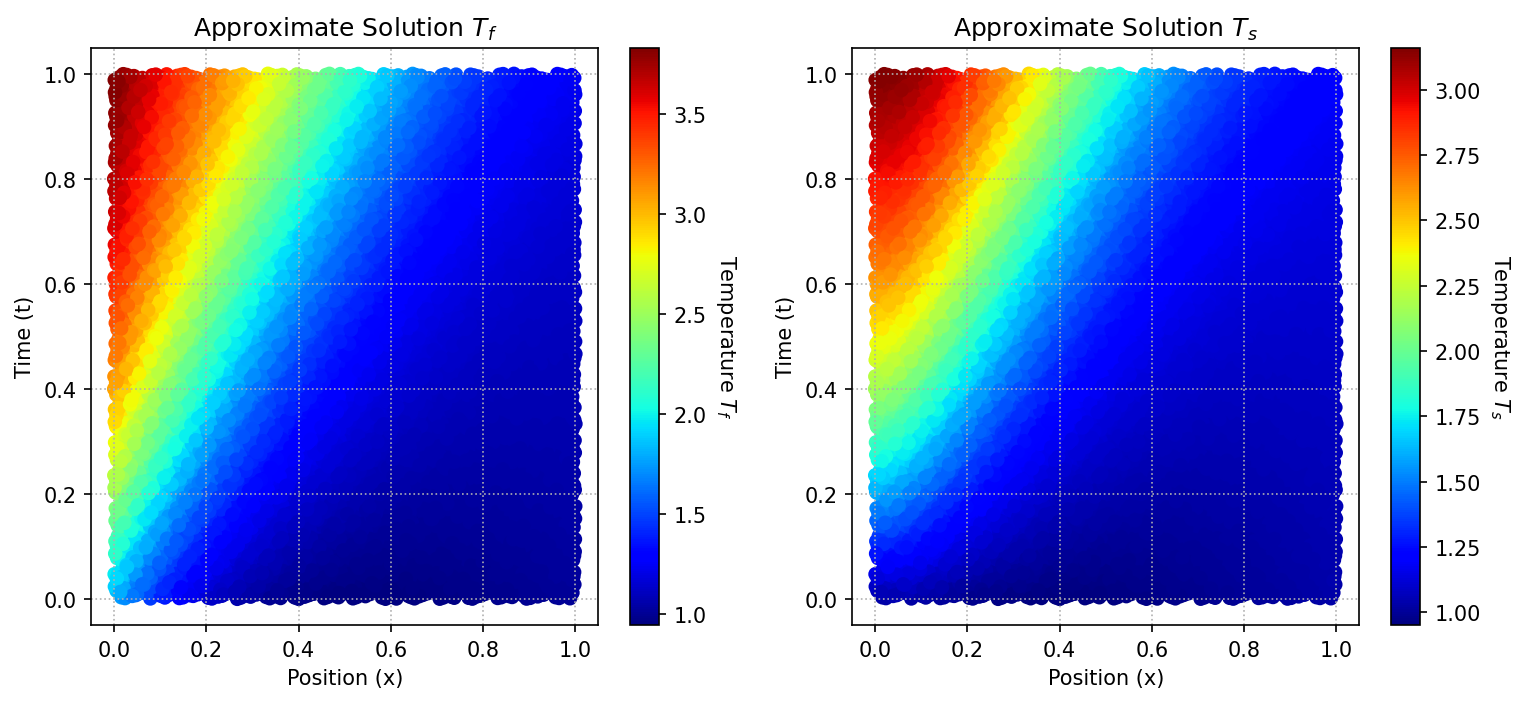

Number of epoch 501
Total loss:  0.7295 | PDE Loss:  0.1493 | Conditions Loss:  0.5802
Number of epoch 502
Total loss:  0.7273 | PDE Loss:  0.1484 | Conditions Loss:  0.5788
Number of epoch 503
Total loss:  0.7251 | PDE Loss:  0.1476 | Conditions Loss:  0.5775
Number of epoch 504
Total loss:  0.7229 | PDE Loss:  0.1468 | Conditions Loss:  0.5761
Number of epoch 505
Total loss:  0.7207 | PDE Loss:  0.146 | Conditions Loss:  0.5747
Number of epoch 506
Total loss:  0.7185 | PDE Loss:  0.1452 | Conditions Loss:  0.5733
Number of epoch 507
Total loss:  0.7164 | PDE Loss:  0.1444 | Conditions Loss:  0.572
Number of epoch 508
Total loss:  0.7142 | PDE Loss:  0.1436 | Conditions Loss:  0.5706
Number of epoch 509
Total loss:  0.7121 | PDE Loss:  0.1429 | Conditions Loss:  0.5692
Number of epoch 510
Total loss:  0.7099 | PDE Loss:  0.1421 | Conditions Loss:  0.5678
Number of epoch 511
Total loss:  0.7078 | PDE Loss:  0.1414 | Conditions Loss:  0.5664
Number of epoch 512
Total loss:  0.7057 | PDE

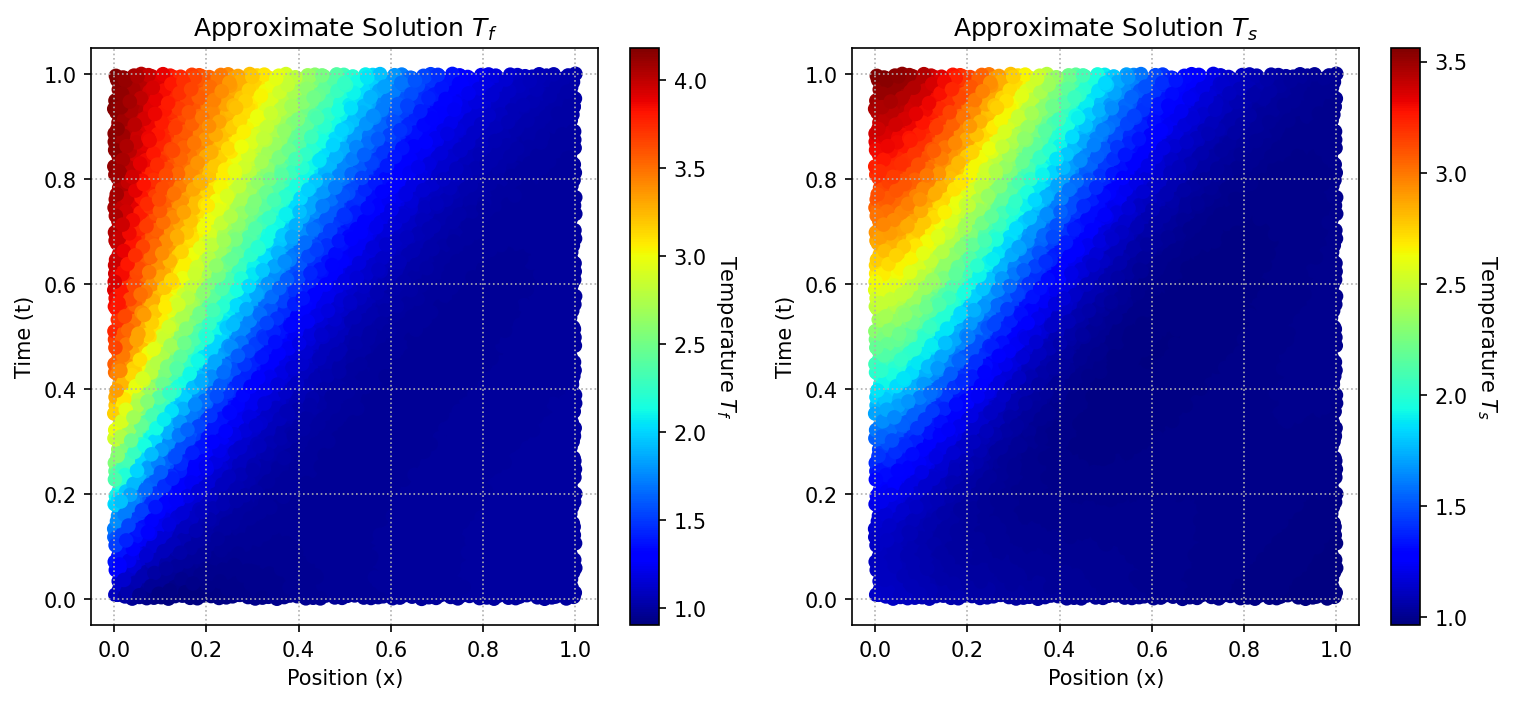

Number of epoch 1001
Total loss:  0.115 | PDE Loss:  0.021 | Conditions Loss:  0.094
Number of epoch 1002
Total loss:  0.1146 | PDE Loss:  0.0209 | Conditions Loss:  0.0937
Number of epoch 1003
Total loss:  0.1143 | PDE Loss:  0.0209 | Conditions Loss:  0.0934
Number of epoch 1004
Total loss:  0.1139 | PDE Loss:  0.0209 | Conditions Loss:  0.093
Number of epoch 1005
Total loss:  0.1136 | PDE Loss:  0.0209 | Conditions Loss:  0.0927
Number of epoch 1006
Total loss:  0.1132 | PDE Loss:  0.0208 | Conditions Loss:  0.0924
Number of epoch 1007
Total loss:  0.1129 | PDE Loss:  0.0208 | Conditions Loss:  0.0921
Number of epoch 1008
Total loss:  0.1126 | PDE Loss:  0.0208 | Conditions Loss:  0.0918
Number of epoch 1009
Total loss:  0.1122 | PDE Loss:  0.0207 | Conditions Loss:  0.0915
Number of epoch 1010
Total loss:  0.1119 | PDE Loss:  0.0207 | Conditions Loss:  0.0912
Number of epoch 1011
Total loss:  0.1115 | PDE Loss:  0.0207 | Conditions Loss:  0.0909
Number of epoch 1012
Total loss:  0.

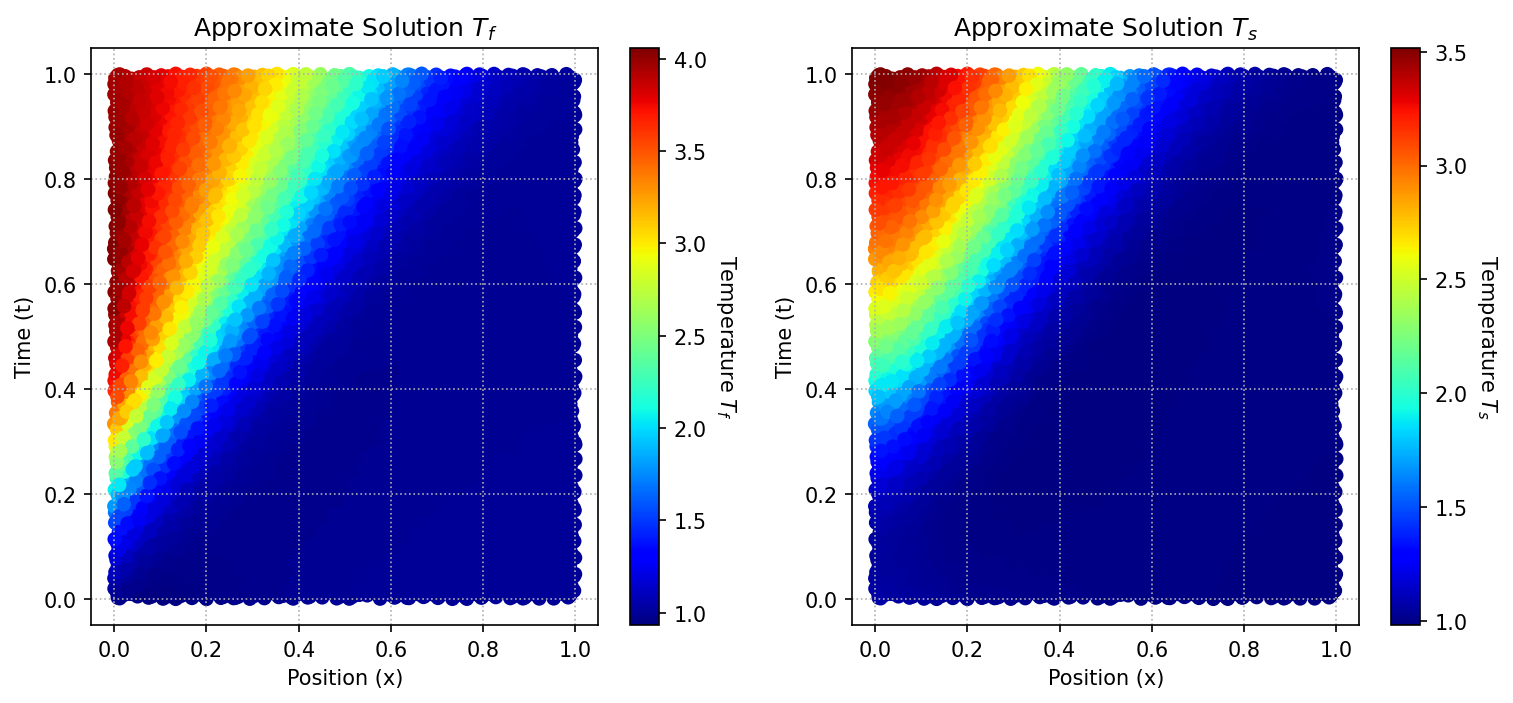

Number of epoch 1501
Total loss:  0.0331 | PDE Loss:  0.0139 | Conditions Loss:  0.0192
Number of epoch 1502
Total loss:  0.033 | PDE Loss:  0.0139 | Conditions Loss:  0.0191
Number of epoch 1503
Total loss:  0.0329 | PDE Loss:  0.0139 | Conditions Loss:  0.0191
Number of epoch 1504
Total loss:  0.0328 | PDE Loss:  0.0138 | Conditions Loss:  0.019
Number of epoch 1505
Total loss:  0.0328 | PDE Loss:  0.0138 | Conditions Loss:  0.0189
Number of epoch 1506
Total loss:  0.0327 | PDE Loss:  0.0138 | Conditions Loss:  0.0189
Number of epoch 1507
Total loss:  0.0326 | PDE Loss:  0.0138 | Conditions Loss:  0.0188
Number of epoch 1508
Total loss:  0.0326 | PDE Loss:  0.0138 | Conditions Loss:  0.0188
Number of epoch 1509
Total loss:  0.0325 | PDE Loss:  0.0138 | Conditions Loss:  0.0187
Number of epoch 1510
Total loss:  0.0324 | PDE Loss:  0.0138 | Conditions Loss:  0.0187
Number of epoch 1511
Total loss:  0.0324 | PDE Loss:  0.0138 | Conditions Loss:  0.0186
Number of epoch 1512
Total loss:  

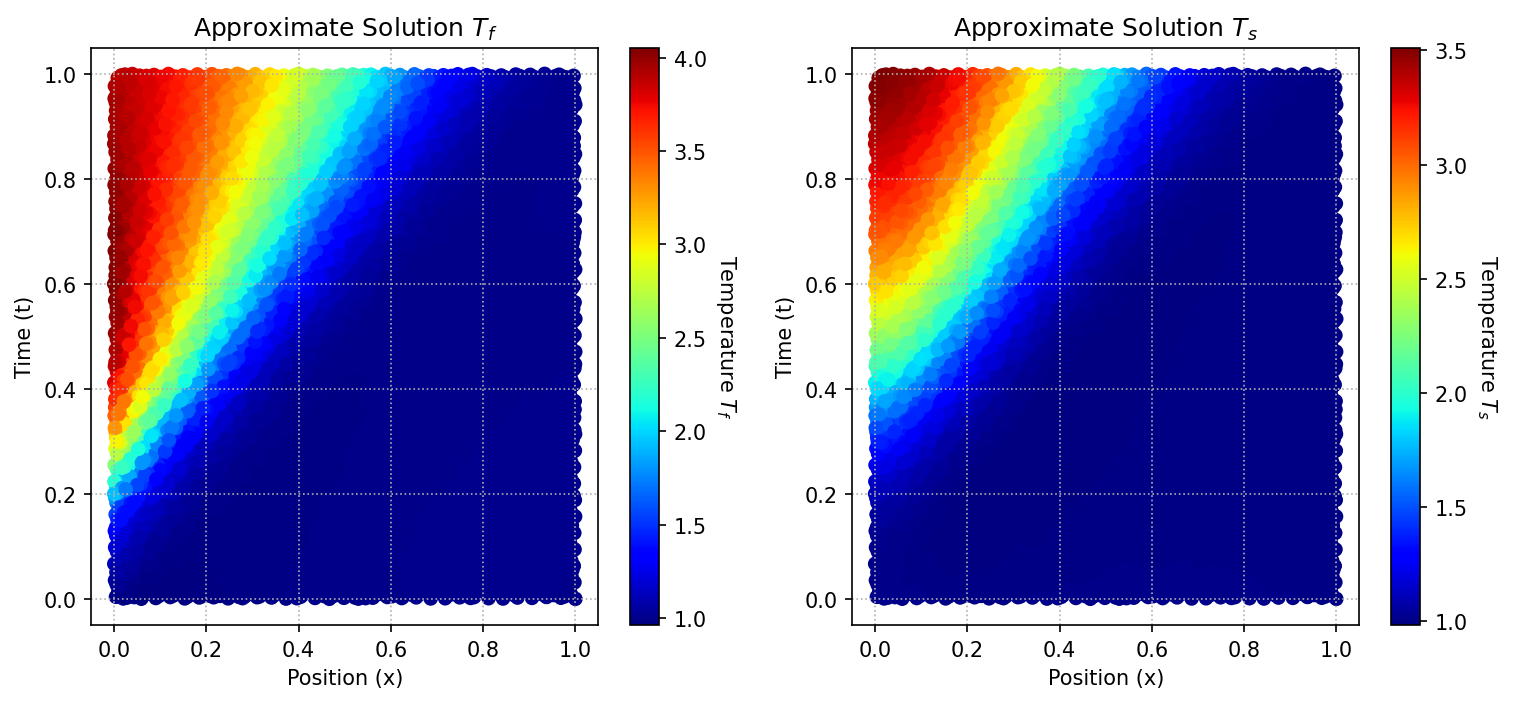

Number of epoch 2001
Total loss:  0.0157 | PDE Loss:  0.0091 | Conditions Loss:  0.0067
Number of epoch 2002
Total loss:  0.0158 | PDE Loss:  0.0092 | Conditions Loss:  0.0066
Number of epoch 2003
Total loss:  0.0157 | PDE Loss:  0.009 | Conditions Loss:  0.0067
Number of epoch 2004
Total loss:  0.0156 | PDE Loss:  0.0091 | Conditions Loss:  0.0065
Number of epoch 2005
Total loss:  0.0155 | PDE Loss:  0.0091 | Conditions Loss:  0.0065
Number of epoch 2006
Total loss:  0.0156 | PDE Loss:  0.009 | Conditions Loss:  0.0065
Number of epoch 2007
Total loss:  0.0156 | PDE Loss:  0.0091 | Conditions Loss:  0.0065
Number of epoch 2008
Total loss:  0.0156 | PDE Loss:  0.009 | Conditions Loss:  0.0066
Number of epoch 2009
Total loss:  0.0155 | PDE Loss:  0.0091 | Conditions Loss:  0.0064
Number of epoch 2010
Total loss:  0.0154 | PDE Loss:  0.009 | Conditions Loss:  0.0064
Number of epoch 2011
Total loss:  0.0154 | PDE Loss:  0.009 | Conditions Loss:  0.0064
Number of epoch 2012
Total loss:  0.0

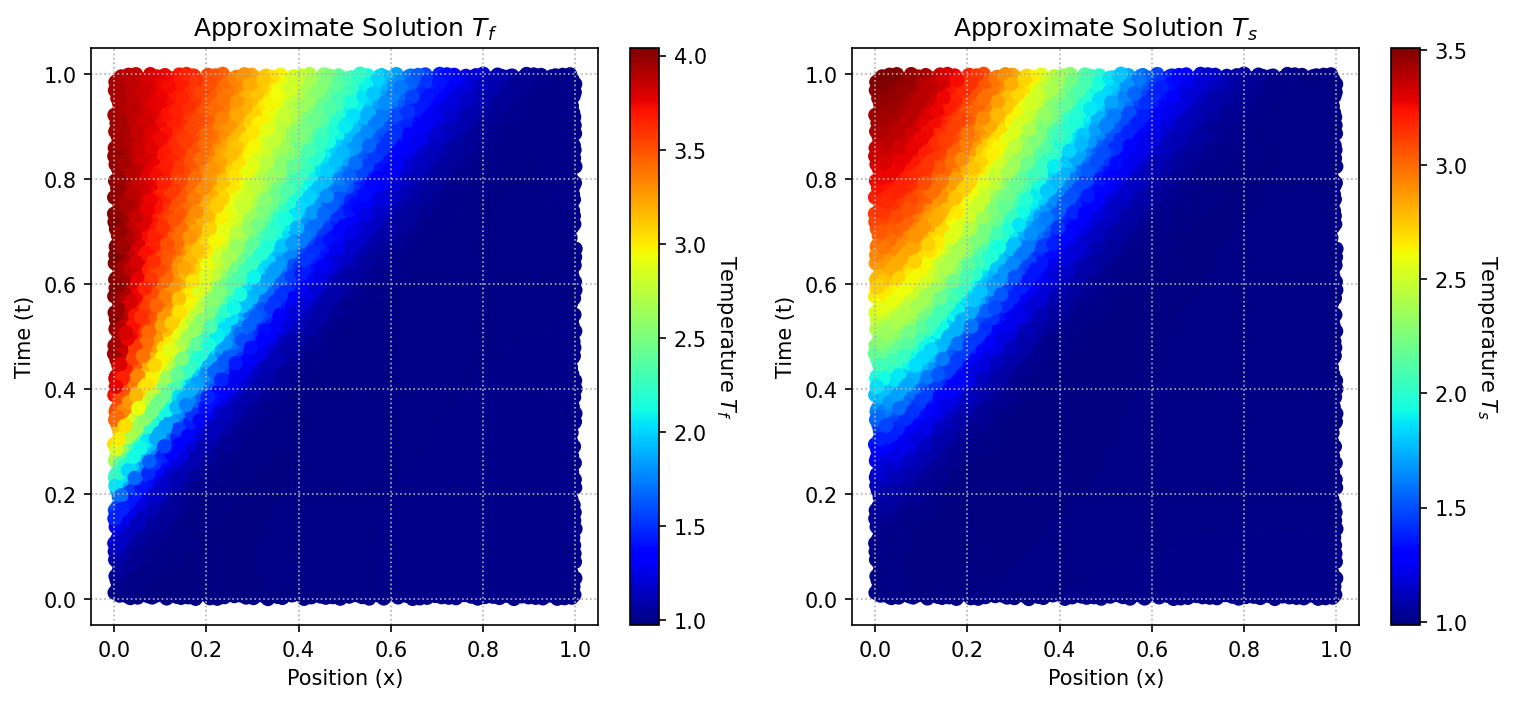

Number of epoch 2501
Total loss:  0.01 | PDE Loss:  0.0063 | Conditions Loss:  0.0037
Number of epoch 2502
Total loss:  0.01 | PDE Loss:  0.0063 | Conditions Loss:  0.0037
Number of epoch 2503
Total loss:  0.0101 | PDE Loss:  0.0063 | Conditions Loss:  0.0038
Number of epoch 2504
Total loss:  0.0102 | PDE Loss:  0.0063 | Conditions Loss:  0.0039
Number of epoch 2505
Total loss:  0.0102 | PDE Loss:  0.0063 | Conditions Loss:  0.0039
Number of epoch 2506
Total loss:  0.0101 | PDE Loss:  0.0063 | Conditions Loss:  0.0038
Number of epoch 2507
Total loss:  0.01 | PDE Loss:  0.0063 | Conditions Loss:  0.0037
Number of epoch 2508
Total loss:  0.0099 | PDE Loss:  0.0063 | Conditions Loss:  0.0037
Number of epoch 2509
Total loss:  0.01 | PDE Loss:  0.0063 | Conditions Loss:  0.0037
Number of epoch 2510
Total loss:  0.01 | PDE Loss:  0.0062 | Conditions Loss:  0.0038
Number of epoch 2511
Total loss:  0.01 | PDE Loss:  0.0063 | Conditions Loss:  0.0037
Number of epoch 2512
Total loss:  0.01 | PDE

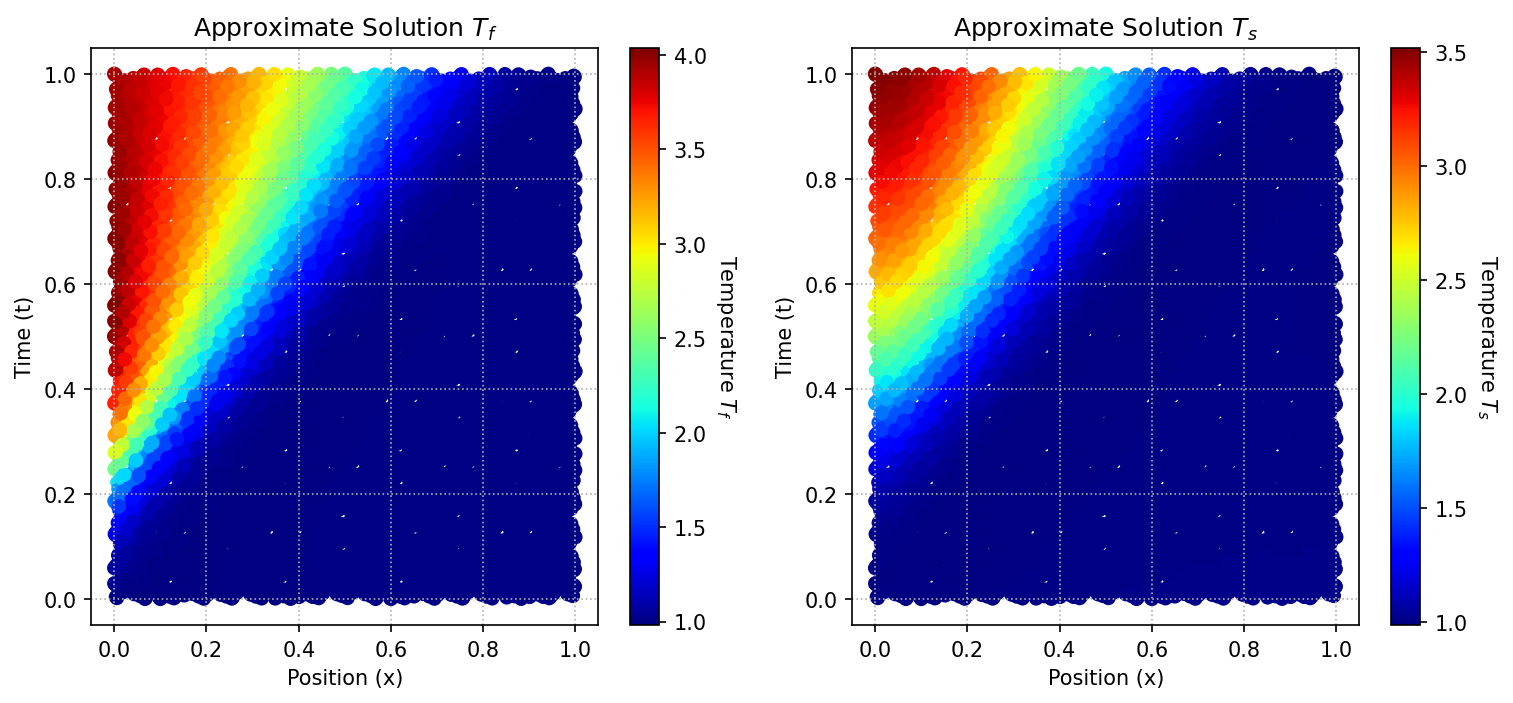

Number of epoch 3001
Total loss:  0.0073 | PDE Loss:  0.0047 | Conditions Loss:  0.0026
Number of epoch 3002
Total loss:  0.0073 | PDE Loss:  0.0047 | Conditions Loss:  0.0026
Number of epoch 3003
Total loss:  0.0073 | PDE Loss:  0.0047 | Conditions Loss:  0.0026
Number of epoch 3004
Total loss:  0.0073 | PDE Loss:  0.0047 | Conditions Loss:  0.0026
Number of epoch 3005
Total loss:  0.0073 | PDE Loss:  0.0047 | Conditions Loss:  0.0026
Number of epoch 3006
Total loss:  0.0073 | PDE Loss:  0.0047 | Conditions Loss:  0.0026
Number of epoch 3007
Total loss:  0.0073 | PDE Loss:  0.0047 | Conditions Loss:  0.0026
Number of epoch 3008
Total loss:  0.0073 | PDE Loss:  0.0047 | Conditions Loss:  0.0026
Number of epoch 3009
Total loss:  0.0073 | PDE Loss:  0.0047 | Conditions Loss:  0.0026
Number of epoch 3010
Total loss:  0.0073 | PDE Loss:  0.0047 | Conditions Loss:  0.0026
Number of epoch 3011
Total loss:  0.0073 | PDE Loss:  0.0047 | Conditions Loss:  0.0026
Number of epoch 3012
Total loss:

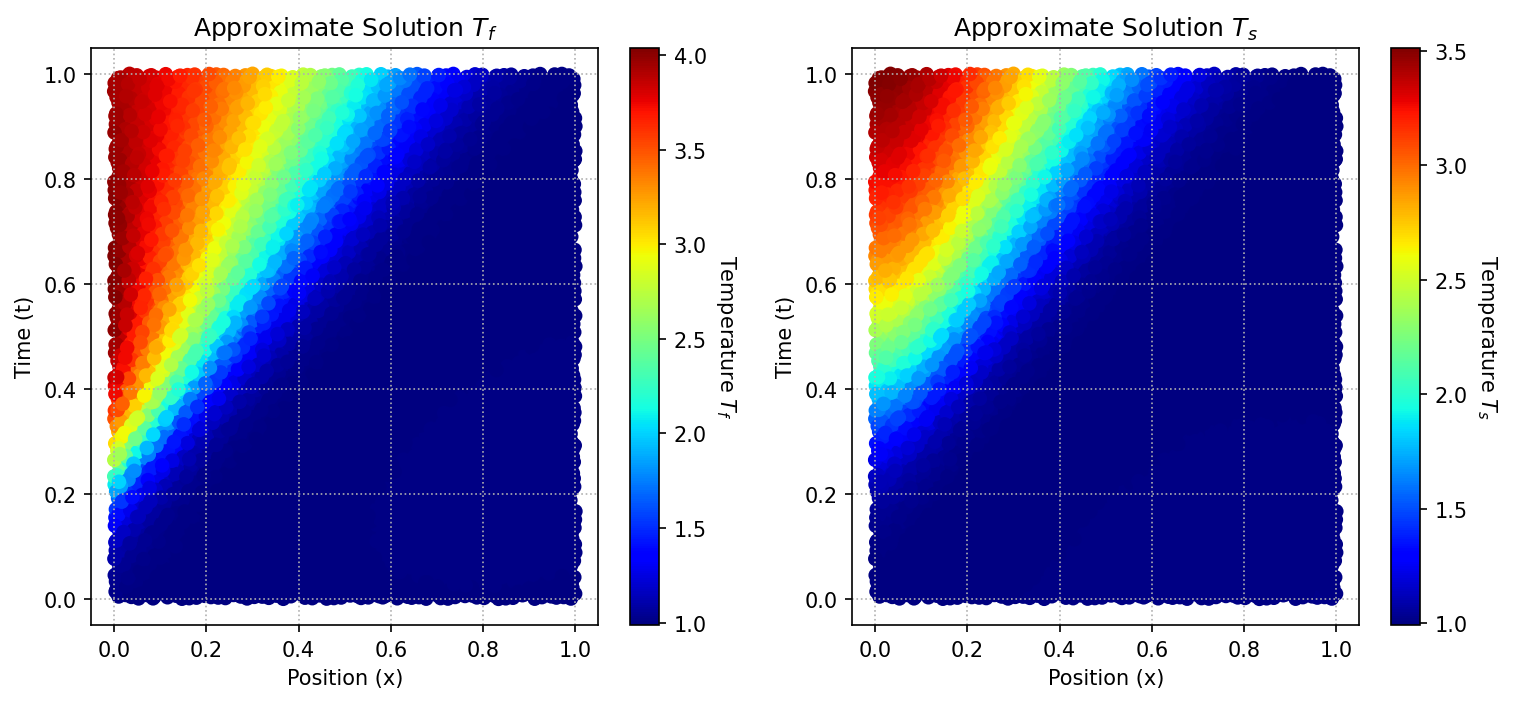

Number of epoch 3501
Total loss:  0.0058 | PDE Loss:  0.0037 | Conditions Loss:  0.002
Number of epoch 3502
Total loss:  0.0058 | PDE Loss:  0.0037 | Conditions Loss:  0.002
Number of epoch 3503
Total loss:  0.0058 | PDE Loss:  0.0037 | Conditions Loss:  0.002
Number of epoch 3504
Total loss:  0.0058 | PDE Loss:  0.0037 | Conditions Loss:  0.002
Number of epoch 3505
Total loss:  0.0058 | PDE Loss:  0.0037 | Conditions Loss:  0.002
Number of epoch 3506
Total loss:  0.0058 | PDE Loss:  0.0037 | Conditions Loss:  0.002
Number of epoch 3507
Total loss:  0.0058 | PDE Loss:  0.0037 | Conditions Loss:  0.002
Number of epoch 3508
Total loss:  0.0058 | PDE Loss:  0.0037 | Conditions Loss:  0.002
Number of epoch 3509
Total loss:  0.0058 | PDE Loss:  0.0037 | Conditions Loss:  0.002
Number of epoch 3510
Total loss:  0.0057 | PDE Loss:  0.0037 | Conditions Loss:  0.002
Number of epoch 3511
Total loss:  0.0057 | PDE Loss:  0.0037 | Conditions Loss:  0.002
Number of epoch 3512
Total loss:  0.0057 | 

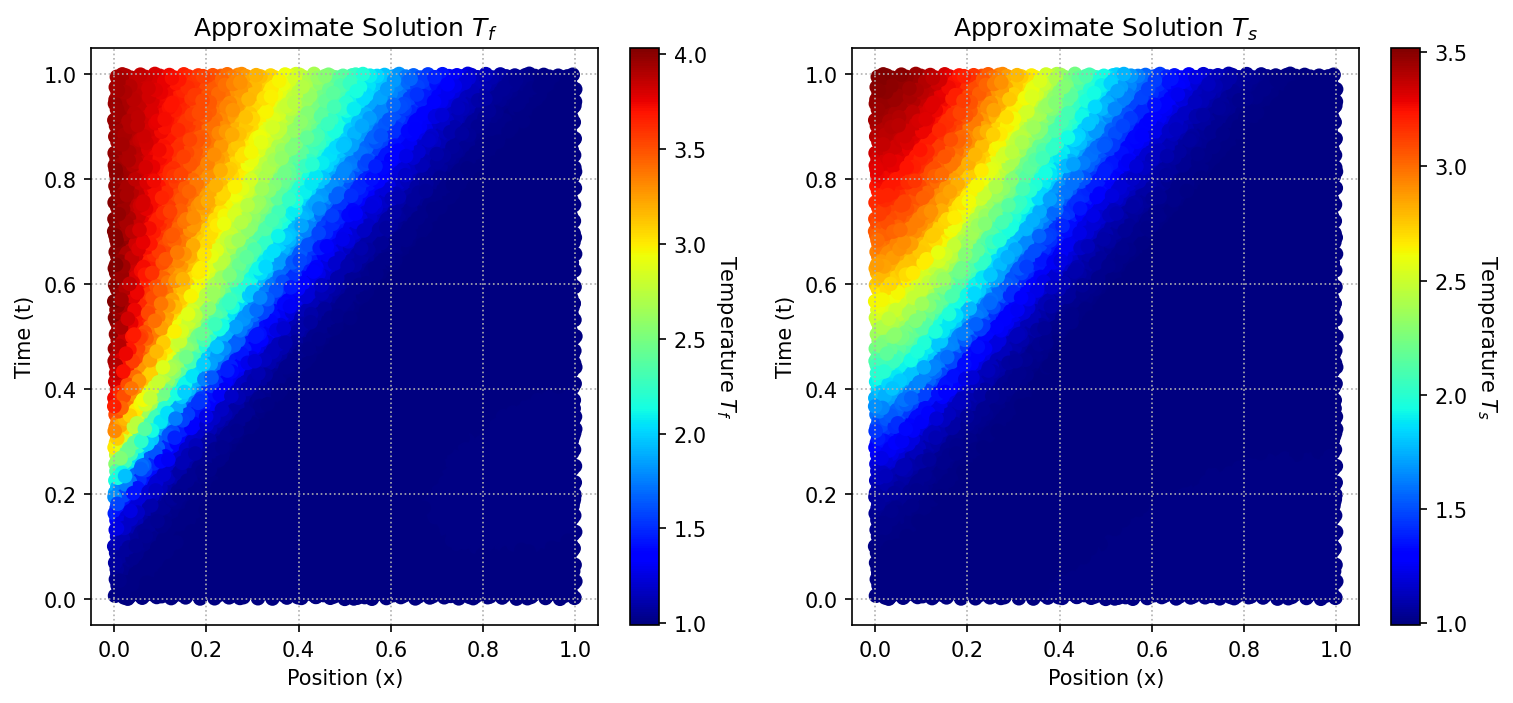

Number of epoch 4001
Total loss:  0.0048 | PDE Loss:  0.0031 | Conditions Loss:  0.0017
Number of epoch 4002
Total loss:  0.0048 | PDE Loss:  0.0031 | Conditions Loss:  0.0017
Number of epoch 4003
Total loss:  0.0048 | PDE Loss:  0.0031 | Conditions Loss:  0.0017
Number of epoch 4004
Total loss:  0.0048 | PDE Loss:  0.0031 | Conditions Loss:  0.0017
Number of epoch 4005
Total loss:  0.0048 | PDE Loss:  0.0031 | Conditions Loss:  0.0017
Number of epoch 4006
Total loss:  0.0047 | PDE Loss:  0.0031 | Conditions Loss:  0.0017
Number of epoch 4007
Total loss:  0.0047 | PDE Loss:  0.0031 | Conditions Loss:  0.0017
Number of epoch 4008
Total loss:  0.0047 | PDE Loss:  0.003 | Conditions Loss:  0.0017
Number of epoch 4009
Total loss:  0.0047 | PDE Loss:  0.003 | Conditions Loss:  0.0017
Number of epoch 4010
Total loss:  0.0047 | PDE Loss:  0.003 | Conditions Loss:  0.0017
Number of epoch 4011
Total loss:  0.0047 | PDE Loss:  0.003 | Conditions Loss:  0.0017
Number of epoch 4012
Total loss:  0.

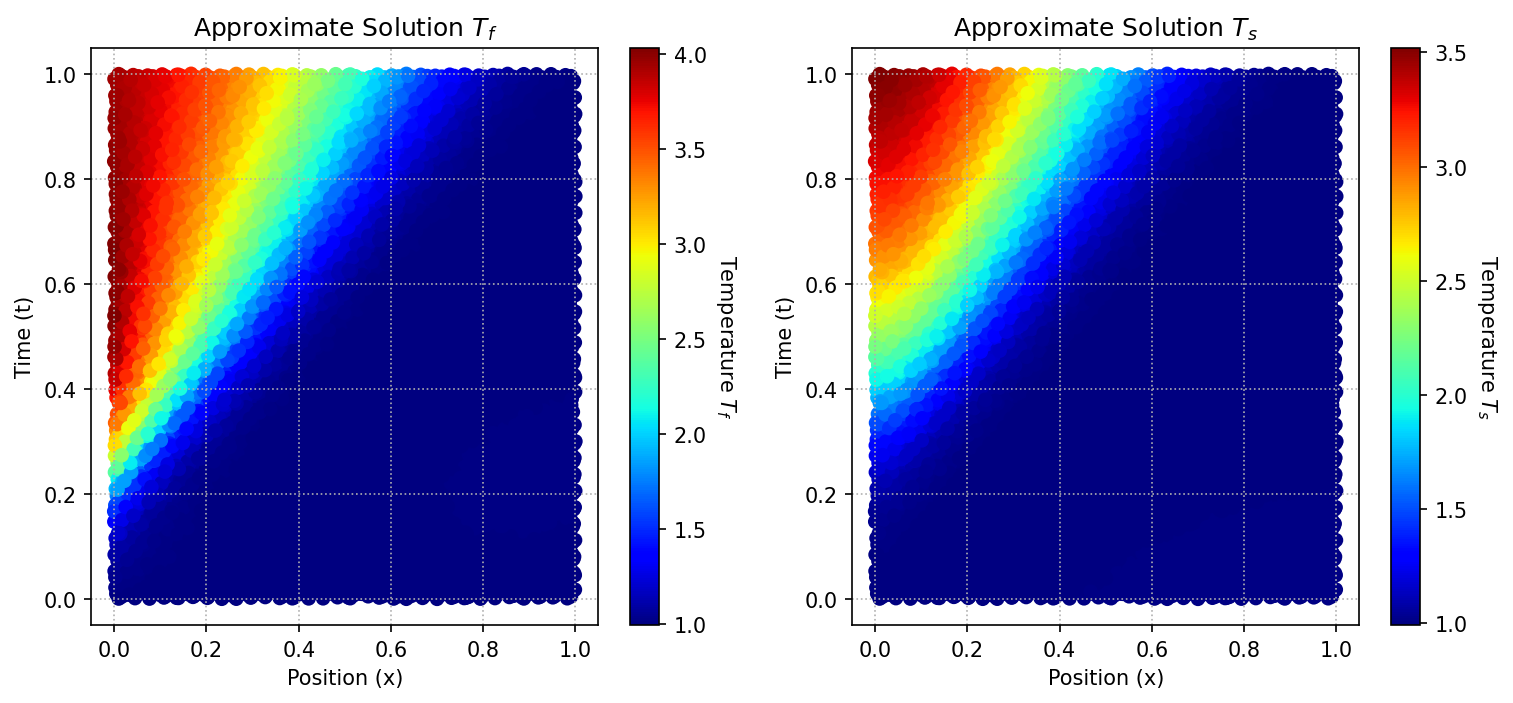

Number of epoch 4501
Total loss:  0.0071 | PDE Loss:  0.0054 | Conditions Loss:  0.0016
Number of epoch 4502
Total loss:  0.0083 | PDE Loss:  0.0065 | Conditions Loss:  0.0018
Number of epoch 4503
Total loss:  0.01 | PDE Loss:  0.0081 | Conditions Loss:  0.0019
Number of epoch 4504
Total loss:  0.0119 | PDE Loss:  0.0097 | Conditions Loss:  0.0021
Number of epoch 4505
Total loss:  0.0139 | PDE Loss:  0.0117 | Conditions Loss:  0.0022
Number of epoch 4506
Total loss:  0.0153 | PDE Loss:  0.0128 | Conditions Loss:  0.0025
Number of epoch 4507
Total loss:  0.0154 | PDE Loss:  0.013 | Conditions Loss:  0.0024
Number of epoch 4508
Total loss:  0.0138 | PDE Loss:  0.0113 | Conditions Loss:  0.0025
Number of epoch 4509
Total loss:  0.0106 | PDE Loss:  0.0084 | Conditions Loss:  0.0022
Number of epoch 4510
Total loss:  0.007 | PDE Loss:  0.0051 | Conditions Loss:  0.0019
Number of epoch 4511
Total loss:  0.0046 | PDE Loss:  0.003 | Conditions Loss:  0.0016
Number of epoch 4512
Total loss:  0.0

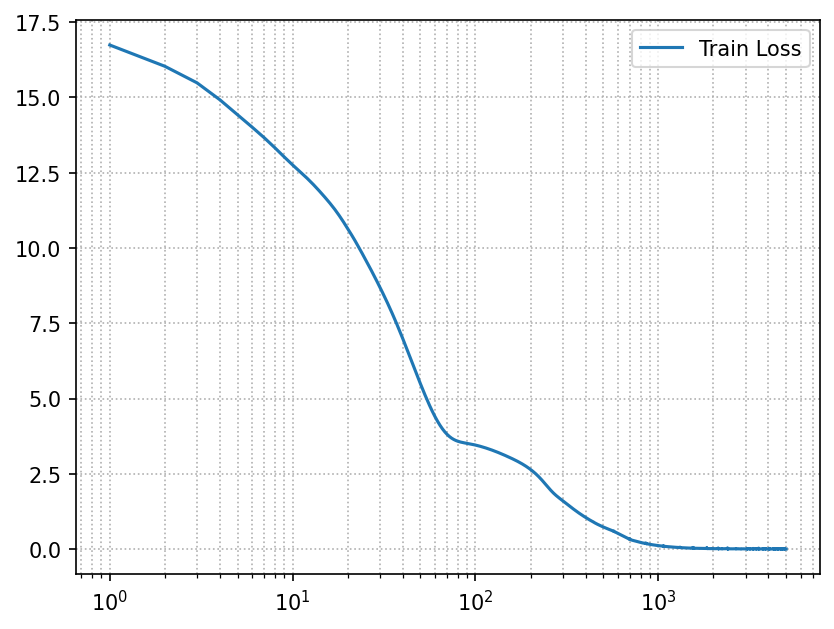

In [63]:
# Define hyperparameters
n_points = 256
n_boundary = 64
n_initial = 64

solver = PINN(n_points, n_boundary, n_initial)

# Set up optimizer
optimizer_LBFGS = optim.LBFGS(solver.model.parameters(), lr=0.5, max_iter=50000, max_eval=50000, history_size=150, line_search_fn="strong_wolfe")
optimizer_ADAM = optim.Adam(solver.model.parameters(), lr=0.001)

# Train the model
history = solver.fit(epochs=5000, optimizer=optimizer_ADAM)

# Plot training loss history
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(history) + 1), history, label="Train Loss")
plt.xscale("log")
plt.legend()
plt.show()


In [11]:
# Save the model
torch.save(solver.model.state_dict(), 'hyperparameters.pth')
solver.model.load_state_dict(torch.load("hyperparameters.pth"))

<ipython-input-11-d5ba92c9b6c3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  solver.model.load_state_dict(torch.load("hyperparameters.pth"))


<All keys matched successfully>

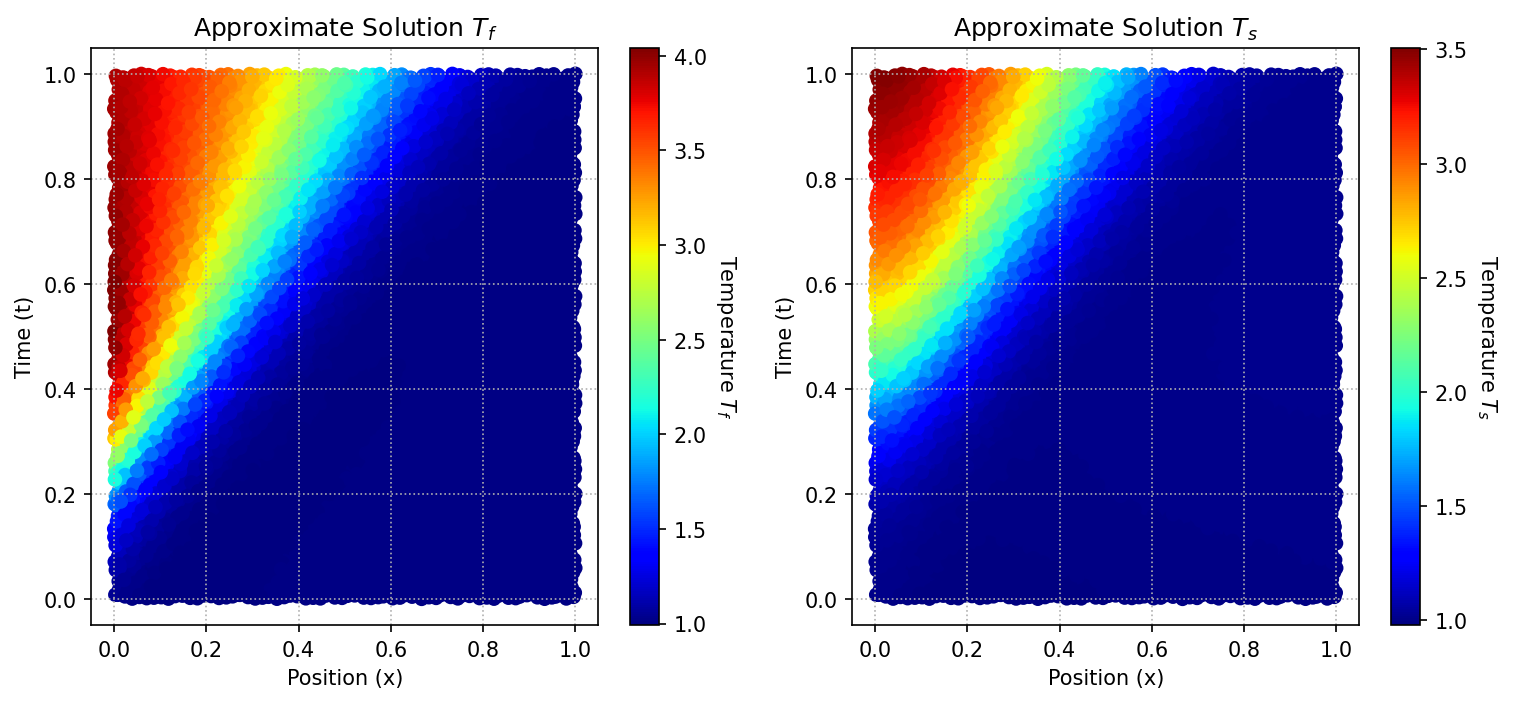

In [60]:
# solver
test_points = solver.sobol_gen.draw(10000)

output = solver.model(test_points)

Tf_pred = output[:, 0].reshape(-1,)
Ts_pred = output[:, 1].reshape(-1,)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# Plot for Tf
im1 = axs[0].scatter(test_points[:, 0].detach(), test_points[:, 1].detach(), c=Tf_pred.detach(), cmap="jet")
axs[0].set_xlabel("Position (x)")
axs[0].set_ylabel("Time (t)")
axs[0].grid(True, which="both", ls=":")
axs[0].set_title("Approximate Solution $T_f$")
# Colorbar for Tf plot
cbar1 = plt.colorbar(im1, ax=axs[0])
cbar1.set_label("Temperature $T_f$", rotation=270, labelpad=15)

# Plot for T_s
im2 = axs[1].scatter(test_points[:, 0].detach(), test_points[:, 1].detach(), c=Ts_pred.detach(), cmap="jet")
axs[1].set_xlabel("Position (x)")
axs[1].set_ylabel("Time (t)")
axs[1].grid(True, which="both", ls=":")
axs[1].set_title("Approximate Solution $T_s$")

cbar2 = plt.colorbar(im2, ax=axs[1])
cbar2.set_label("Temperature $T_s$", rotation=270, labelpad=15)

plt.show()

In [52]:
test_data = pd.read_csv("TestingData.txt", delimiter=',')
test_data = test_data[["x","t"]]
display(test_data)

t_test = torch.tensor(test_data['t'].values, dtype=torch.float32).reshape(-1, 1)
x_test = torch.tensor(test_data['x'].values, dtype=torch.float32).reshape(-1, 1)

test_data_tensor = torch.tensor(test_data.values, dtype=torch.float32)

x         t
0      0.895  0.624062
1      0.778  0.783512
2      0.469  0.398106
3      0.948  0.415906
4      0.457  0.949750
...      ...       ...
99995  0.697  0.811444
99996  0.248  0.498512
99997  0.100  0.718912
99998  0.247  0.953963
99999  0.740  0.463612

[100000 rows x 2 columns]

In [53]:
solution_test_data = solver.model(test_data_tensor)

In [54]:
solver.model(torch.tensor([[0.,0.]]))

tensor([[1.0337, 1.0020]], grad_fn=<AddmmBackward0>)

In [55]:
save_path_pred = "Quy Le"

test_pred = test_data.copy()
test_pred['tf'] = solution_test_data[:, 0].detach().numpy()
test_pred['ts'] = solution_test_data[:, 1].detach().numpy()
display(test_pred)

test_pred.to_csv("{}/Task1.txt".format(save_path_pred), header=True, index=None, sep=',', mode='w')

x         t        tf        ts
0      0.895  0.624062  1.008464  1.014933
1      0.778  0.783512  1.020514  1.011107
2      0.469  0.398106  1.005092  1.001939
3      0.948  0.415906  1.006122  1.011640
4      0.457  0.949750  2.445661  1.986418
...      ...       ...       ...       ...
99995  0.697  0.811444  1.077831  1.029282
99996  0.248  0.498512  1.842508  1.316092
99997  0.100  0.718912  3.633478  2.932274
99998  0.247  0.953963  3.339283  2.946115
99999  0.740  0.463612  1.005488  1.009673

[100000 rows x 4 columns]

OSError: Cannot save file into a non-existent directory: 'Quy Le'

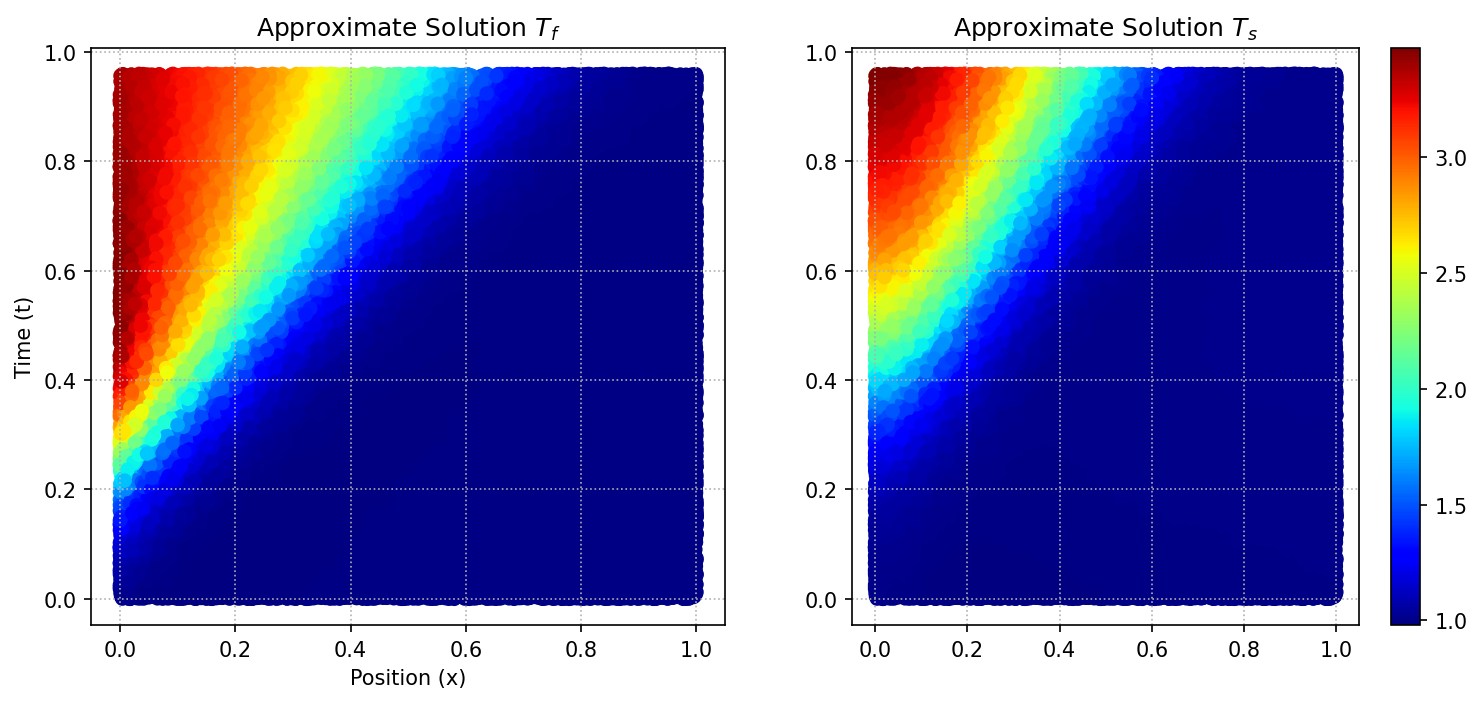

In [56]:
output = solver.model(test_data_tensor)
output_Tf = output[:, 0].reshape(-1, )
output_Ts = output[:, 1].reshape(-1, )

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
im1 = axs[0].scatter(test_data_tensor[:, 0].detach(), test_data_tensor[:, 1].detach(), c=output_Tf.detach(), cmap="jet")
axs[0].set_xlabel("Position (x)")
axs[0].set_ylabel("Time (t)")

axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(test_data_tensor[:, 0].detach(), test_data_tensor[:, 1].detach(), c=output_Ts.detach(), cmap="jet")
axs[0].set_xlabel("Position (x)")
axs[0].set_ylabel("Time (t)")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Approximate Solution $T_f$")
axs[1].set_title("Approximate Solution $T_s$")

plt.show()

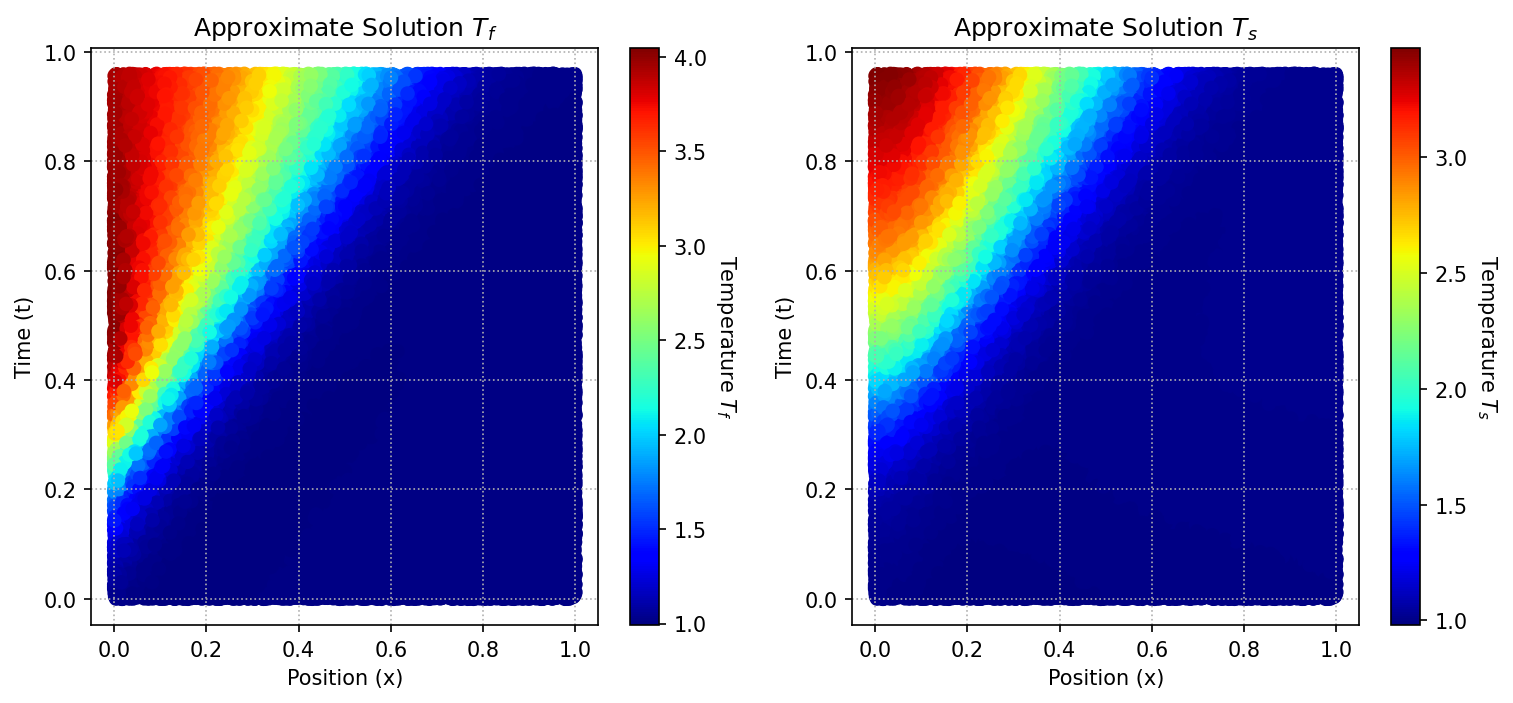

In [57]:
import matplotlib.pyplot as plt

# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# Plot for T_f
im1 = axs[0].scatter(test_data_tensor[:, 0].detach(), test_data_tensor[:, 1].detach(), c=output_Tf.detach(), cmap="jet")
axs[0].set_xlabel("Position (x)")
axs[0].set_ylabel("Time (t)")
axs[0].grid(True, which="both", ls=":")
axs[0].set_title("Approximate Solution $T_f$")
# Colorbar for the first plot
cbar1 = plt.colorbar(im1, ax=axs[0])
cbar1.set_label("Temperature $T_f$", rotation=270, labelpad=15)  # Set the label for the colorbar

# Plot for T_s
im2 = axs[1].scatter(test_data_tensor[:, 0].detach(), test_data_tensor[:, 1].detach(), c=output_Ts.detach(), cmap="jet")
axs[1].set_xlabel("Position (x)")
axs[1].set_ylabel("Time (t)")
axs[1].grid(True, which="both", ls=":")
axs[1].set_title("Approximate Solution $T_s$")
# Colorbar for the second plot
cbar2 = plt.colorbar(im2, ax=axs[1])
cbar2.set_label("Temperature $T_s$", rotation=270, labelpad=15)  # Set the label for the colorbar

# Display the plot
plt.show()


In [ ]:
summary(solver.model, input_size=(240,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 240, 20]              60
              Tanh-2              [-1, 240, 20]               0
            Linear-3              [-1, 240, 20]             420
              Tanh-4              [-1, 240, 20]               0
            Linear-5              [-1, 240, 20]             420
              Tanh-6              [-1, 240, 20]               0
            Linear-7              [-1, 240, 20]             420
              Tanh-8              [-1, 240, 20]               0
            Linear-9               [-1, 240, 2]              42
Total params: 1,362
Trainable params: 1,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.01
Estimated Total Size (MB): 0.30
-----------------------------------------------